In [9]:
import sys,os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches


workpath = os.getcwd()
libpath = workpath + "/libs/"
figpath = workpath + "/figs/"
outpath = workpath + "/out/"
distpath = workpath + "/input/osm-primnet/"
grbpath = workpath + "/gurobi/"
homepath = workpath + "/input/load/121-home-load.csv"


sys.path.append(libpath)
from pyExtractlib import get_home_load, GetDistNet
from pyDrawNetworklib import DrawNodes,DrawEdges
from pySchedEVChargelib import solve_ADMM, compute_Rmat

print("Imported modules and libraries")


s = 6
all_homes = get_home_load(homepath,shift=s)
dist = GetDistNet(distpath,121144)
res = [n for n in dist if dist.nodes[n]['label']=='H']
print("\nLoaded network with "+str(len(res))+" residences")

# Area of interest where EV adoption is studied
xmin = -80.37217
ymin = 37.1993
xmax = xmin + 0.010
ymax = ymin + 0.005
res_interest = [n for n in res if (xmin<=dist.nodes[n]['cord'][0]<=xmax) and (ymin<=dist.nodes[n]['cord'][1]<=ymax)]
print("\nArea selected for EV adoption study")

Imported modules and libraries

Loaded network with 1126 residences

Area selected for EV adoption study


In [10]:
np.random.seed(1234)
adoption = 0.1
num_choice = int(adoption * len(res_interest))
ev_home = np.random.choice(res_interest,num_choice,replace=False)

homes = {}
for h in res:
    homes[h] = {}
    homes[h]["LOAD"] = [l for l in all_homes[h]["LOAD"]]
    if h in ev_home:
        homes[h]["EV"] = {"rating":1.2,"capacity":16.0,"initial":0.6,
                                         "final":0.9,"start":11,"end":23}
    else:
        homes[h]["EV"] = {}

# Other input parameters
COST = [1] * 24
vset = 1.02
prefix = "agentEV-"+str(int(100*adoption))+"-adopt"

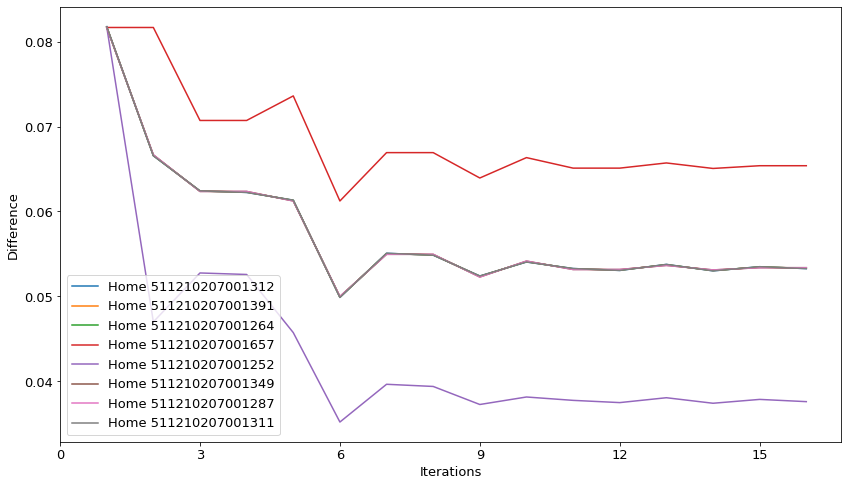

In [11]:
diff,P_res,P_ev,SOC = solve_ADMM(homes,dist,COST,grbpath=grbpath,vset=1.02,vlow=0.9)


# Plot the convergence
num_iter = len(diff)
xtix = range(1,num_iter+1)
fig4 = plt.figure(figsize=(14,8))
ax4 = fig4.add_subplot(1,1,1)
for h in ev_home:
    ax4.plot(xtix,[diff[k][h] for k in xtix],
             label="Home "+str(h))
ax4.set_ylabel("Difference",fontsize=13)
ax4.set_xlabel("Iterations",fontsize=13)
ax4.legend(loc='best',ncol=1,prop={'size': 13})
ax4.set_xticks(list(range(0,16,3)))
ax4.tick_params(axis='y', labelsize=13)
ax4.tick_params(axis='x', labelsize=13)
fig4.savefig("{}{}.png".format(figpath,prefix+'-convergence'),
              bbox_inches='tight')

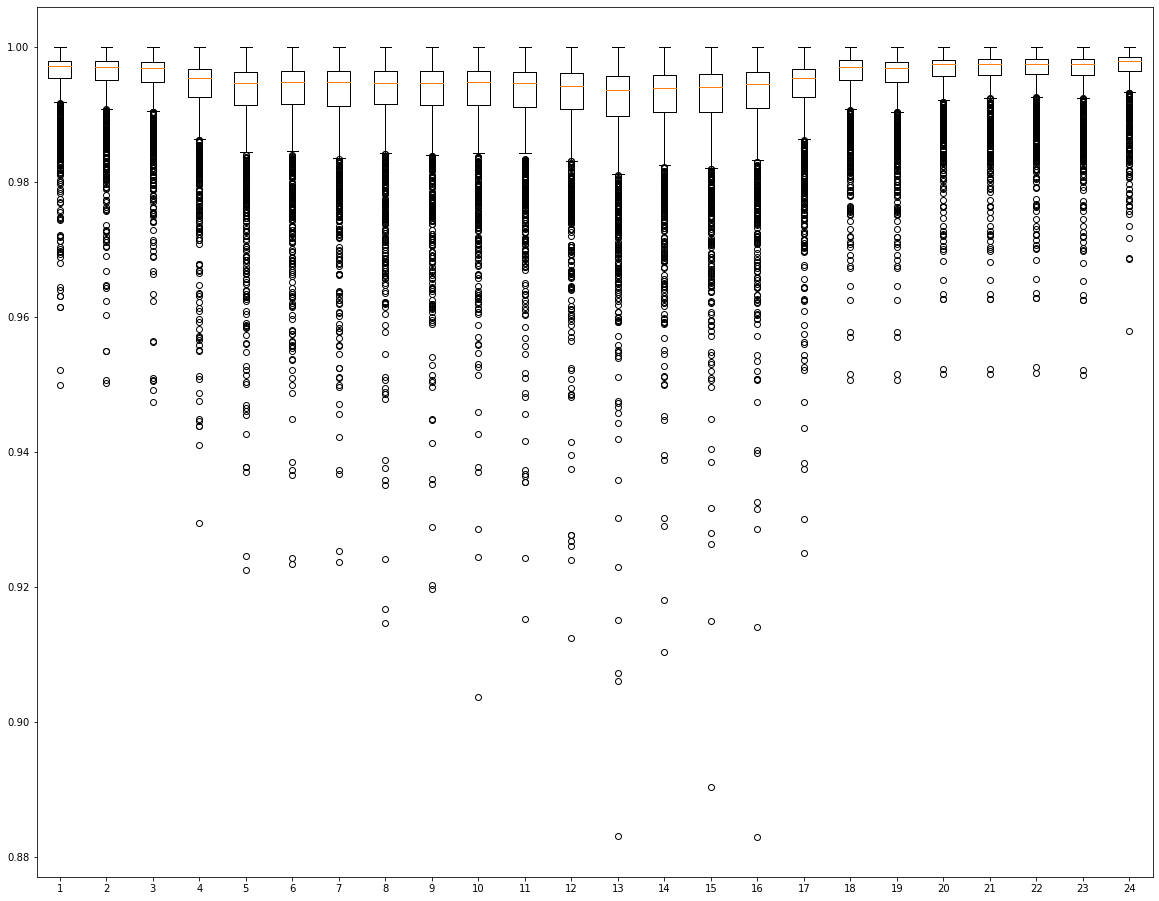

In [12]:
R = compute_Rmat(dist)
nodelist = [n for n in dist if dist.nodes[n]['label']!='S']


P = np.zeros(shape=(len(nodelist),len(COST)))
Z = np.ones(shape=(len(nodelist),len(COST)))
for i,n in enumerate(nodelist):
    if n in res:
        P[i,:] = np.array(P_res[n])

V = np.sqrt(Z - R@P)
volt = {h:V[i,:].tolist() for i,h in enumerate(nodelist) if h in nodelist}
volt_data = [[volt[n][t] for n in res] for t in range(len(COST))]

fig5 = plt.figure(figsize=(20,16))
ax5 = fig5.add_subplot(1,1,1)
d_adopt1 = ax5.boxplot(volt_data)

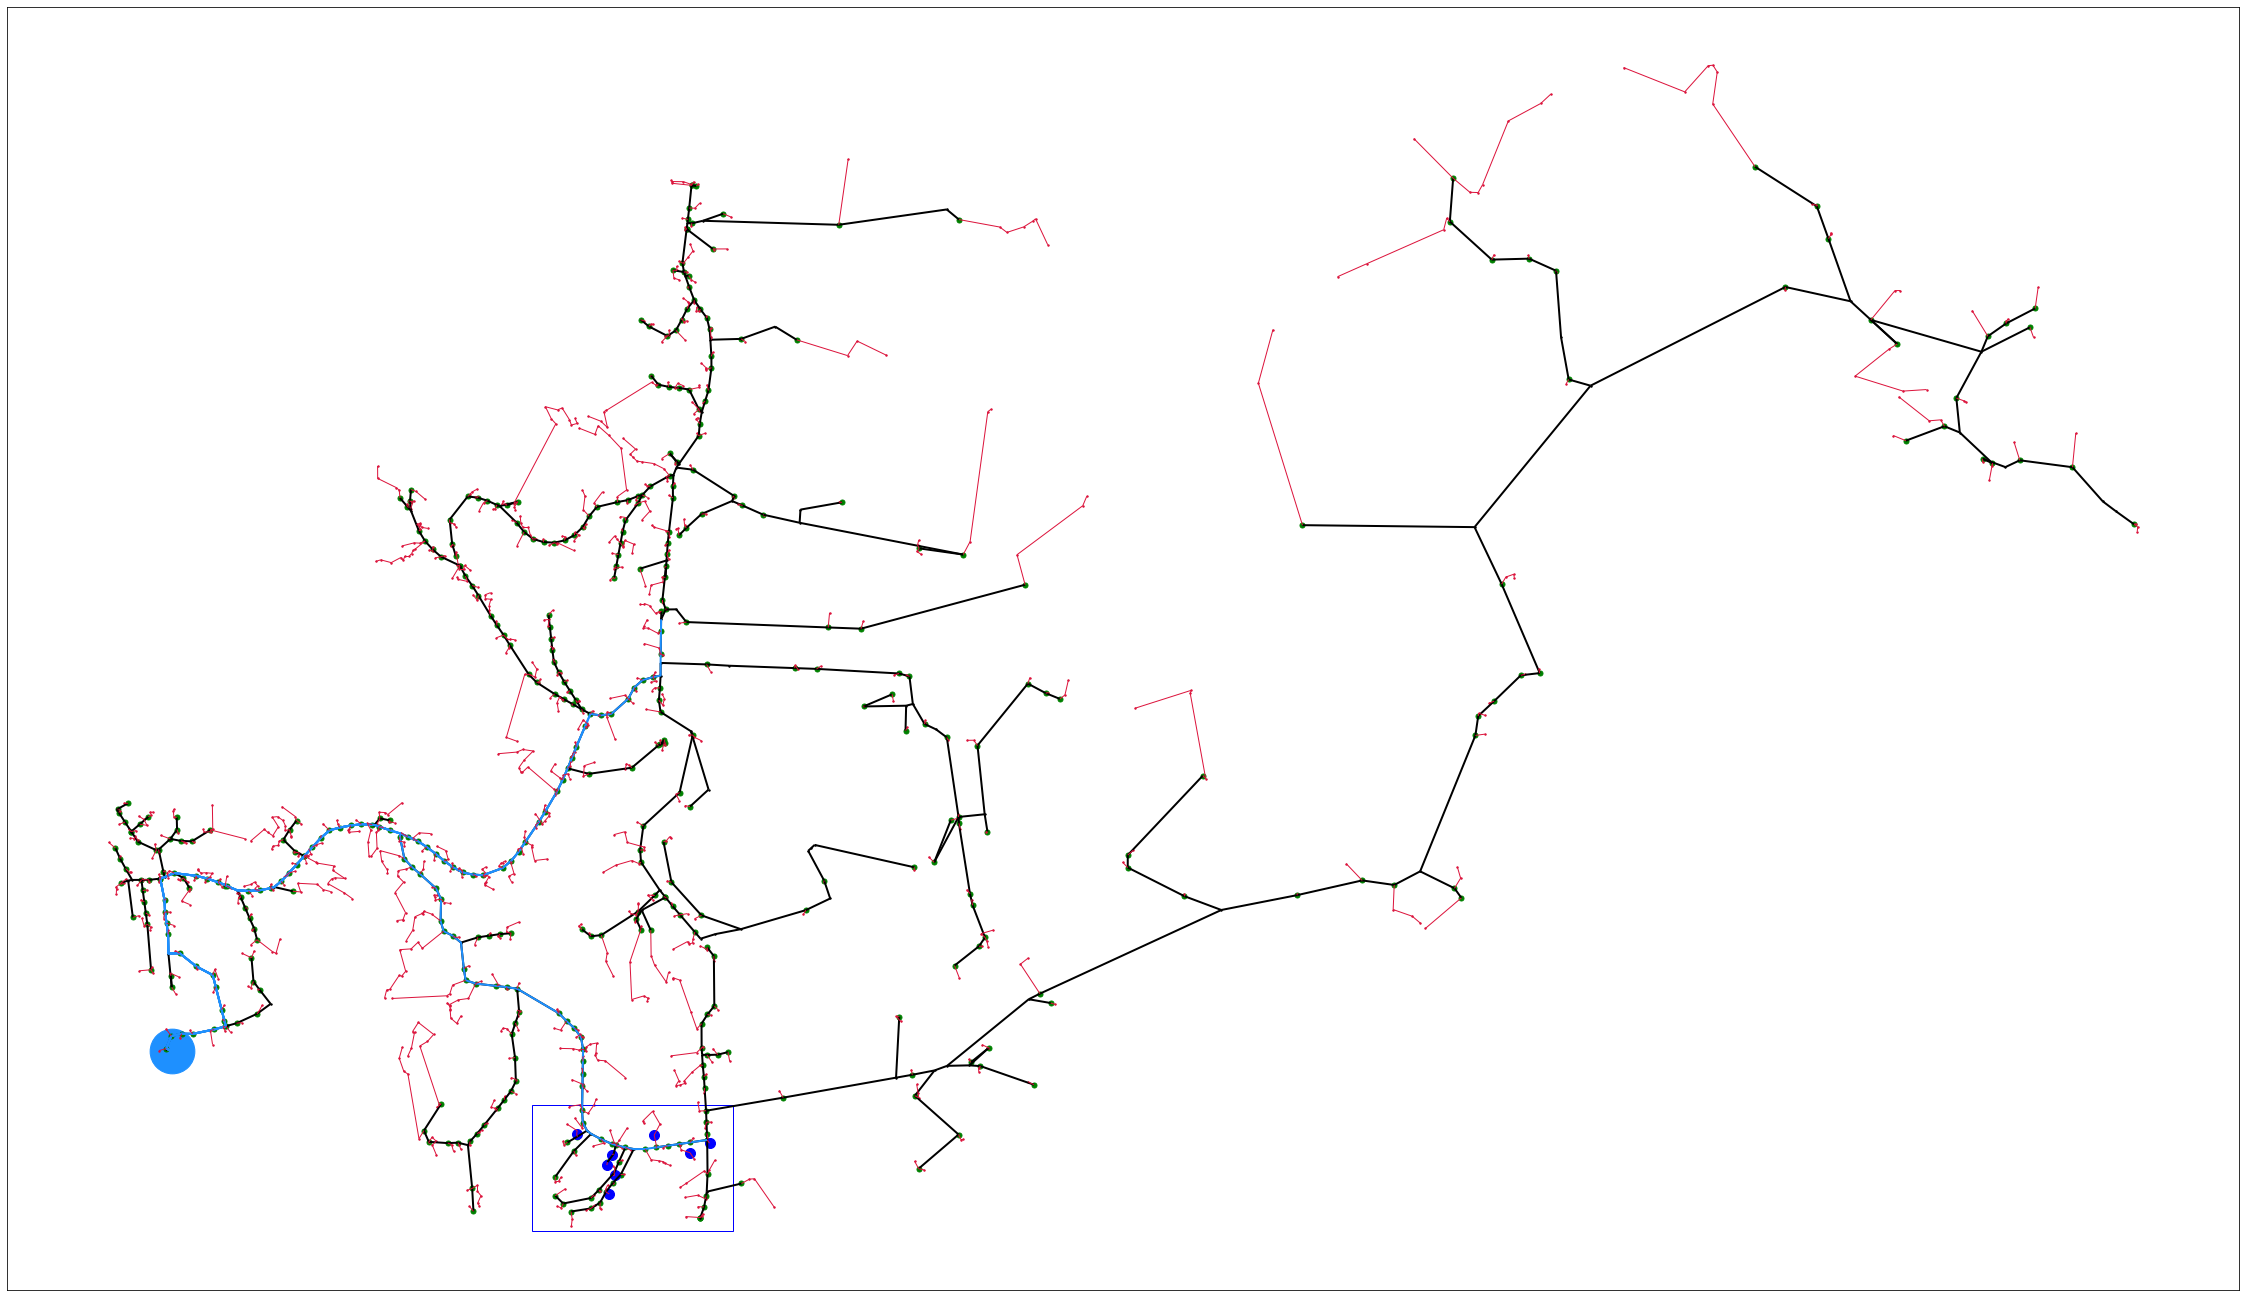

In [13]:
def plot_network(ax,net,path=None,with_secnet=False):
    """
    """
    # Draw nodes
    DrawNodes(net,ax,label='S',color='dodgerblue',size=2000)
    DrawNodes(net,ax,label='T',color='green',size=25)
    DrawNodes(net,ax,label='R',color='black',size=2.0)
    if with_secnet: DrawNodes(net,ax,label='H',color='crimson',size=2.0)
    # Draw edges
    DrawEdges(net,ax,label='P',color='black',width=2.0)
    DrawEdges(net,ax,label='E',color='dodgerblue',width=2.0)
    if with_secnet: DrawEdges(net,ax,label='S',color='crimson',width=1.0)
    ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    if path != None: 
        fig.savefig("{}{}.png".format(path,'-51121-dist'),bbox_inches='tight')
    return ax

fig = plt.figure(figsize=(40,40), dpi=72)
ax = fig.add_subplot(111)
ax = plot_network(ax,dist,with_secnet=True)

# Create a Rectangle patch
rect = patches.Rectangle((-80.37217, 37.1993), 0.01, 0.005, linewidth=1, edgecolor='blue', facecolor='none')
# Add the patch to the Axes to denote the locality
ax.add_patch(rect)
# Add the nodes where EV adoption
x_int = [dist.nodes[n]['cord'][0] for n in ev_home]
y_int = [dist.nodes[n]['cord'][1] for n in ev_home]
ax.scatter(x_int,y_int,s=100.0,c='b')


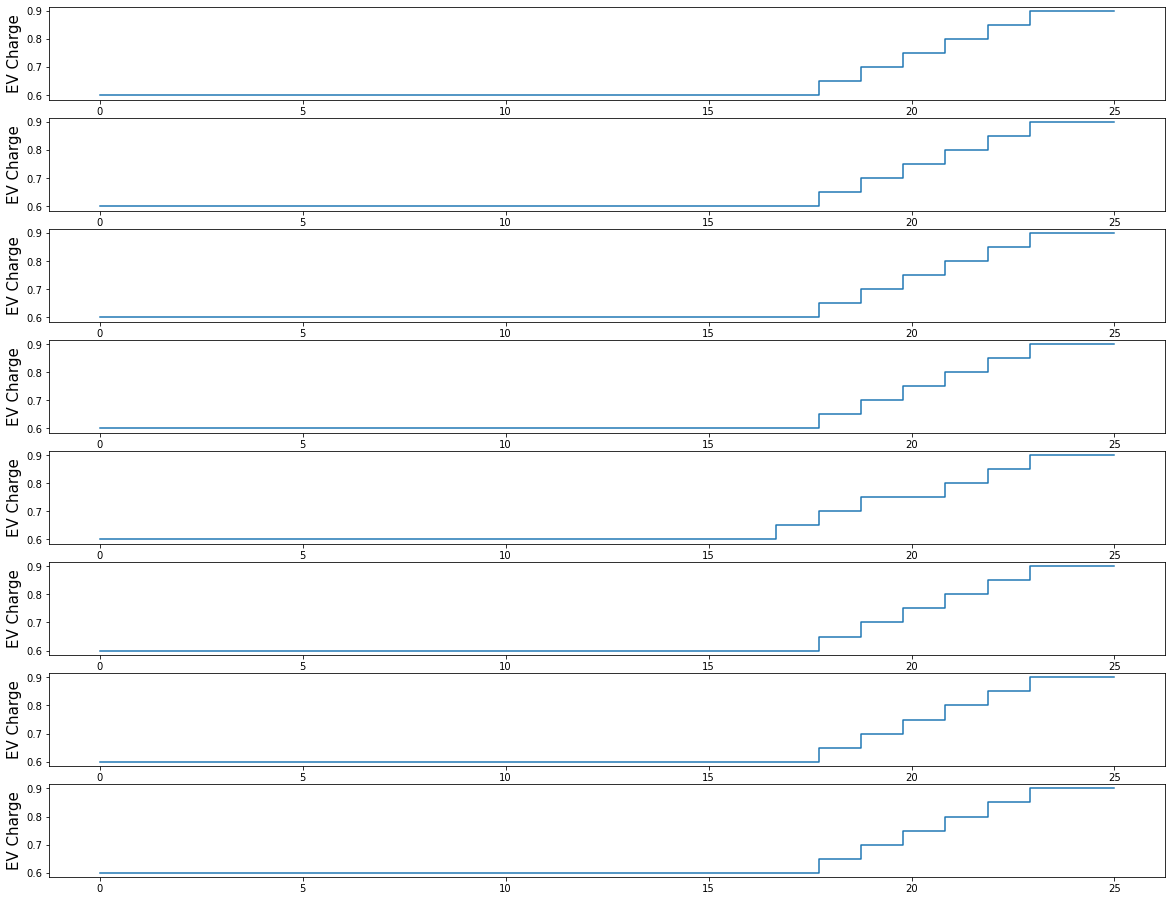

In [16]:
xarray = np.linspace(0,25,25)
fig6 = plt.figure(figsize = (20,16))
for i,h in enumerate(ev_home):
    ax6 = fig6.add_subplot(8,1,i+1)
    ax6.step(xarray,SOC[h])
    ax6.set_ylabel("EV Charge",fontsize=15)
fig6.savefig("{}{}.png".format(figpath,prefix+'-EV-charge'),
            bbox_inches='tight')

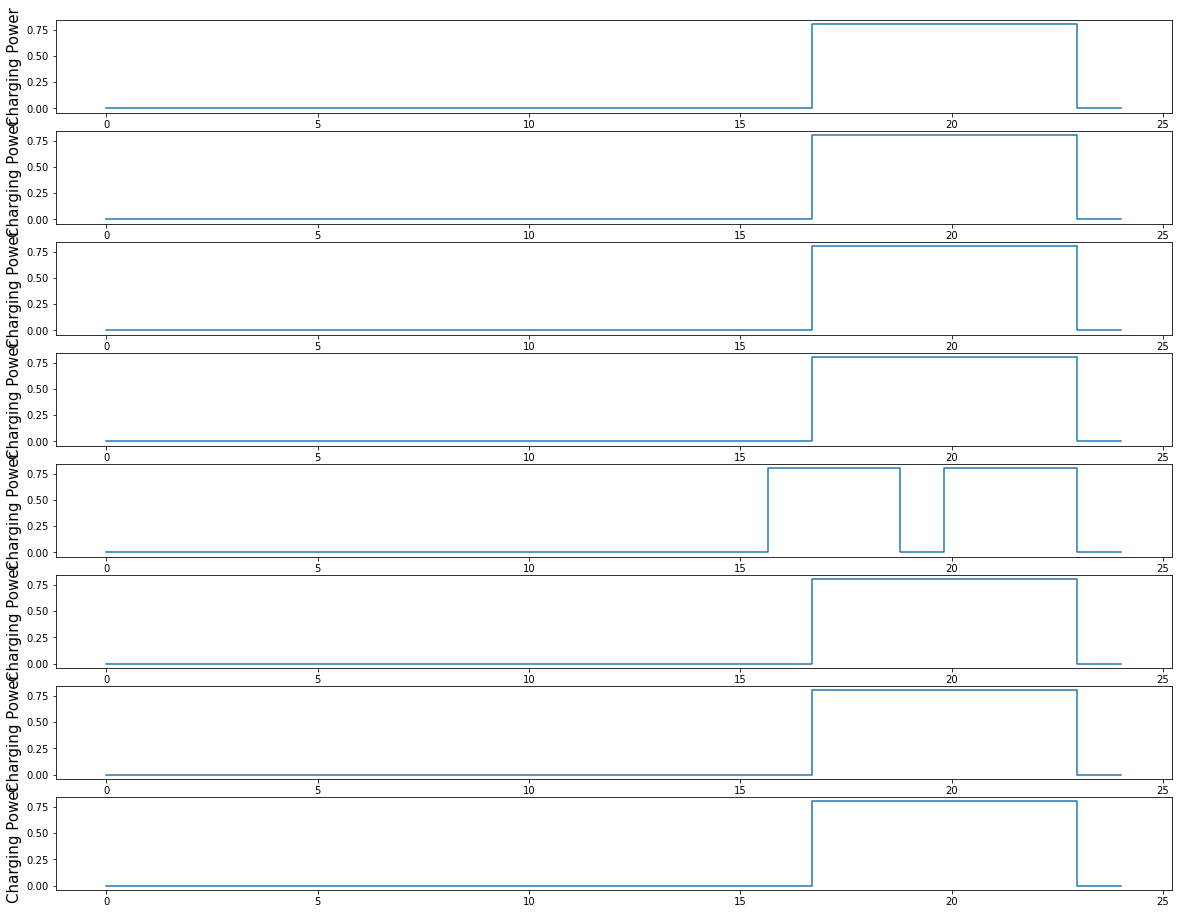

In [17]:
xarray = np.linspace(0,24,24)
fig6 = plt.figure(figsize = (20,16))
for i,h in enumerate(ev_home):
    ax6 = fig6.add_subplot(8,1,i+1)
    ax6.step(xarray,P_ev[h])
    ax6.set_ylabel("Charging Power",fontsize=15)
fig6.savefig("{}{}.png".format(figpath,prefix+'-power-EV'),
            bbox_inches='tight')

In [18]:
ev_home

array([511210207001312, 511210207001391, 511210207001264, 511210207001657,
       511210207001252, 511210207001349, 511210207001287, 511210207001311],
      dtype=int64)